<a href="https://colab.research.google.com/github/ppages01/big-data-challenge/blob/master/aws_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [54]:
import matplotlib.pyplot as plt

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AWS_SAmpe").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option('header', 'true').csv(SparkFiles.get("amazon_reviews_us_Wireless_v1_00.tsv.gz"), inferSchema=True, sep='\t')

# Show DataFrame
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...| 

In [5]:
df.show(10, False)

+-----------+-----------+--------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
df[['star_rating', 'helpful_votes', 'total_votes']].describe()

DataFrame[summary: string, star_rating: string, helpful_votes: string, total_votes: string]

In [7]:
df.columns

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [8]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)



In [9]:
from pyspark.sql.functions import year

# Show the year for the date column
df.select(year(df["review_date"])).show()

+-----------------+
|year(review_date)|
+-----------------+
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
|             2015|
+-----------------+
only showing top 20 rows



In [10]:
df = df.withColumn("fixed_date", year(df['review_date']))
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|fixed_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+----------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|      2015|
|         US|   50800750|R15V54KBMTQWAY|B00X

In [57]:
# Average Rating grouped by verified purchase
df.groupby('verified_purchase').agg({'star_rating':'mean','verified_purchase':'count','helpful_votes':"mean"}).show()

+-----------------+------------------+------------------------+------------------+
|verified_purchase|  avg(star_rating)|count(verified_purchase)|avg(helpful_votes)|
+-----------------+------------------+------------------------+------------------+
|             null|              null|                       0|              null|
|                Y|3.8991187160595966|                 7929340|0.7031393533383611|
|                N| 3.837540010125487|                 1072541|2.2740184291323127|
+-----------------+------------------+------------------------+------------------+



In [12]:
# Looking at vine vs nonvine reviews

In [56]:
tot_vine = df[df['vine']=='Y']
tot_nonvine = df[df['vine'] =='N']
tot_vine.count()
tot_nonvine.count()
print(f"Total number of vine ratings for this category:{tot_vine.count()},  Non-Vine ratings with 4 or above: {tot_nonvine.count()}")

Total number of vine ratings for this category:17481,  Non-Vine ratings with 4 or above: 8984400


In [16]:
# Show all of the occupations where salaries were above 80k
vine_ratings = df[(df['star_rating']> 4) & (df['vine'] == 'Y')]
nonvine_ratings = df[(df['star_rating']> 4) & (df['vine'] == 'N')]



#df.filter('star_rating>4').filter('df.vine'='Y').show()

In [25]:
#rating of 4 or above
print(f"Count of Vine ratings with 4 or above:{vine_ratings.count()},  Non-Vine ratings with 4 or above: {nonvine_ratings.count()}")

Count of Vine ratings with 4 or above:6522,  Non-Vine ratings with 4 or above: 4818203


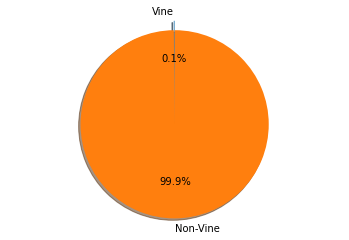

In [49]:

labels = 'Vine', 'Non-Vine'
sizes = [vine_ratings.count(), nonvine_ratings.count()]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()